In [7]:
import os
import glob
import os
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
from tqdm import tqdm
import time
from scanpy.tools._utils import get_init_pos_from_paga 
from sklearn.metrics import mean_squared_error
from scipy.sparse import issparse
import warnings

import torch
import rmm
import cupy
import cudf
import cupy as cp
from rmm.allocators.cupy import rmm_cupy_allocator
import anndata as an
import scanpy as sc
import rapids_singlecell as rsc
import scvi

from cuml.manifold import UMAP
from cuml.decomposition import TruncatedSVD

# Enable `managed_memory`
rmm.reinitialize(
    managed_memory=True,
    pool_allocator=False,
)
cp.cuda.set_allocator(rmm_cupy_allocator)

from tqdm.notebook import tqdm

In [3]:
%%time
fpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/pipeline_outputs/integrated_anndata/cell_cycle/TrajNet_input.h5ad"
adata = sc.read_h5ad(fpath)
adata

CPU times: user 297 ms, sys: 3.22 s, total: 3.52 s
Wall time: 7.49 s


AnnData object with n_obs × n_vars = 6895 × 15906
    obs: 'batch', 'phase', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'n_genes', 'n_reads', 'raw_clusters', 'bbknn_clusters', 'harmony_clusters', 'cluster_str', 'barcoded_phase', 'S_score', 'G2M_score', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices', 'G1_pseudotime', 'G1_order', 'G2M_pseudotime', 'G2M_order', 'mean_pseudotime', 'mean_order', 'nnz', 'velocyto_cell_id', 'cell_id', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'leiden', 'cluster_phase', 'early_g1_score', 'G1_stage', 'global_ordering', 'global_ordering_bin', 'velocity_self_tra

X_magic vs raw_counts    1.714716e+04
scvi vs raw_counts       3.583903e+06
scvi vs X_magic          3.584983e+06
dtype: float64


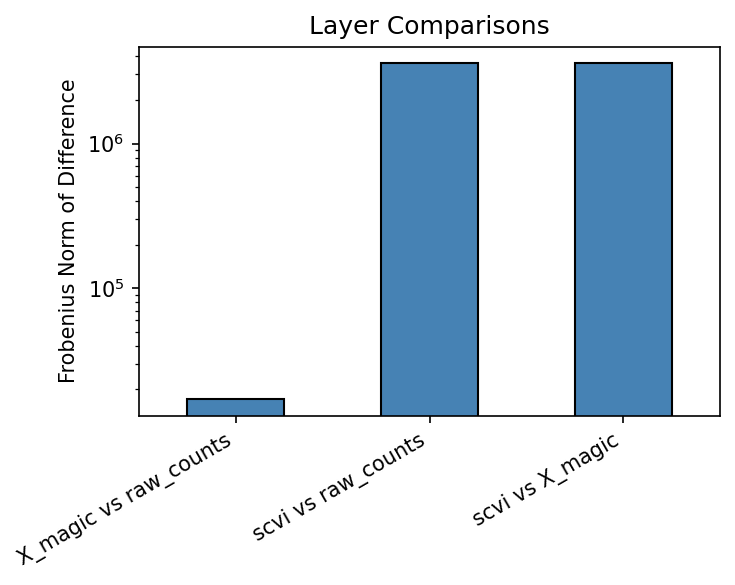

CPU times: user 3.05 s, sys: 1.78 s, total: 4.83 s
Wall time: 2.49 s


In [18]:
%%time 
pairs = [
    ("X_magic", "raw_counts"),
    ("scvi", "raw_counts"),
    ("scvi", "X_magic"),
]

results = {}
for a, b in pairs:
    A = adata.layers[a]
    B = adata.layers[b]

    # Convert sparse to dense if needed
    if issparse(A):
        A = A.toarray()
    if issparse(B):
        B = B.toarray()

    # Frobenius norm of the difference
    diff_norm = np.linalg.norm(A - B, ord="fro")
    results[f"{a} vs {b}"] = diff_norm

# Put results into a Series
series = pd.Series(results)
print(series)

# --- Plot ---
plt.figure(figsize=(5, 4), dpi=150)
series.plot(kind="bar", color="steelblue", edgecolor="black")
plt.yscale('log')
plt.ylabel("Frobenius Norm of Difference")
plt.title("Layer Comparisons")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


In [16]:
%%time
pairs = [
    ("X_magic", "raw_counts"),
    ("scvi", "raw_counts"),
    ("scvi", "X_magic"),
]

for a, b in pairs:
    A = adata.layers[a]
    B = adata.layers[b]

    if issparse(A):
        A = A.toarray()
    if issparse(B):
        B = B.toarray()

    # --- Per-gene Frobenius norm (over cells) ---
    gene_diffs = np.linalg.norm(A - B, axis=0)  # shape: (n_genes,)
    df = pd.DataFrame({
        "gene": adata.var_names,
        "diff_norm": gene_diffs
    }).sort_values("diff_norm", ascending=False)

    print(f"\nTop 10 genes differing for {a} vs {b}:")
    print(df.head(10).to_string(index=False))



Top 10 genes differing for X_magic vs raw_counts:
    gene   diff_norm
   TIMP1 3460.146995
  MALAT1 3402.132869
  S100A6 3395.292276
    MT2A 3217.080806
  TMSB10 2568.035018
  LGALS1 2495.221374
SERPINE2 2490.576511
    FTH1 2104.912558
    TPM1 2061.677082
  IFITM1 2059.637197

Top 10 genes differing for scvi vs raw_counts:
  gene     diff_norm
LGALS1 926107.332285
  MT2A 847944.705531
TMSB10 844819.110587
 RPLP1 824074.726479
S100A6 800987.658366
 RPL28 613446.720472
IFITM3 561645.930299
RPL37A 508749.585785
MALAT1 502661.981249
 TIMP1 460936.237899

Top 10 genes differing for scvi vs X_magic:
  gene     diff_norm
LGALS1 926249.444542
  MT2A 848352.110073
TMSB10 844963.396691
 RPLP1 824188.407761
S100A6 801066.471860
 RPL28 613556.235078
IFITM3 561866.087739
RPL37A 508809.241661
MALAT1 502709.647626
 TIMP1 461136.898474
CPU times: user 927 ms, sys: 2.66 s, total: 3.58 s
Wall time: 3.6 s


Mean per-gene correlations:
X_magic vs raw_counts    0.153989
scvi vs raw_counts       0.106000
scvi vs X_magic          0.087820
dtype: float64


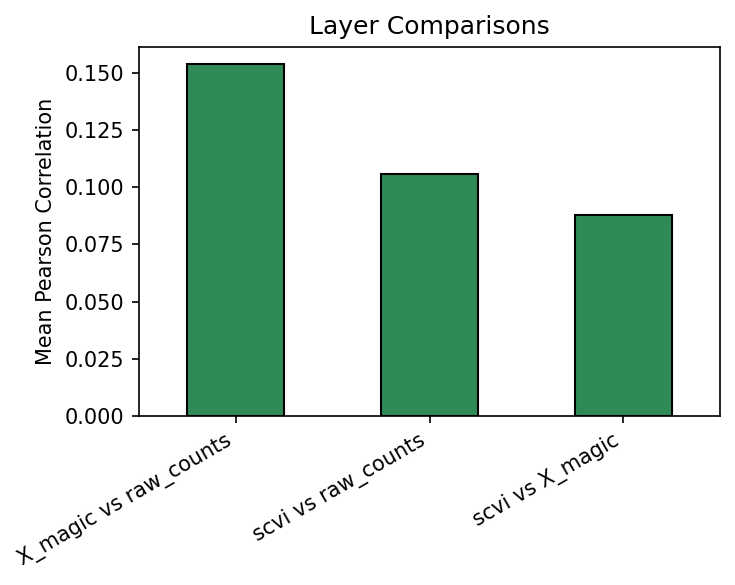


Lowest correlation genes for X_magic vs raw_counts:
           gene     corr
          CRYGS 0.013802
ENSG00000271746 0.014851
ENSG00000275765 0.017919
        FDXACB1 0.018473
      LINC02989 0.018474
ENSG00000290012 0.018494
      HDAC4-AS1 0.019394
      KCNJ5-AS1 0.021345
         JTB-DT 0.021479
ENSG00000279954 0.021939

Highest correlation genes for X_magic vs raw_counts:
  gene     corr
  PPIA 0.840496
 H2AZ1 0.841907
 RPL35 0.843456
 HMGB1 0.846399
  PFN1 0.847856
TUBA1B 0.850631
TMSB10 0.883792
LGALS1 0.904403
MALAT1 0.975895
  MT2A 0.985126

Lowest correlation genes for scvi vs raw_counts:
           gene      corr
          TCF25 -0.126522
          NSRP1 -0.120506
         NDUFV2 -0.115745
         TALDO1 -0.107972
        SLC25A6 -0.100743
           NSA2 -0.098253
         KDELR1 -0.093299
ENSG00000257732 -0.089194
          SRP14 -0.083779
           UPF2 -0.082217

Highest correlation genes for scvi vs raw_counts:
   gene     corr
  H2AZ1 0.865626
  PTTG1 0.866703
   P

In [19]:
pairs = [
    ("X_magic", "raw_counts"),
    ("scvi", "raw_counts"),
    ("scvi", "X_magic"),
]

results = {}
top_genes = {}

for a, b in pairs:
    A = adata.layers[a]
    B = adata.layers[b]

    if issparse(A):
        A = A.toarray()
    if issparse(B):
        B = B.toarray()

    # --- Per-gene correlation ---
    corrs = []
    for i in range(A.shape[1]):  # loop over genes
        if np.all(A[:, i] == 0) and np.all(B[:, i] == 0):
            corrs.append(np.nan)  # skip all-zero genes
        else:
            c = np.corrcoef(A[:, i], B[:, i])[0, 1]
            corrs.append(c)

    corrs = np.array(corrs)
    mean_corr = np.nanmean(corrs)
    results[f"{a} vs {b}"] = mean_corr

    # Save top/bottom 10 genes
    df = pd.DataFrame({
        "gene": adata.var_names,
        "corr": corrs
    }).dropna().sort_values("corr", ascending=True)

    top_genes[f"{a} vs {b}"] = {
        "lowest": df.head(10),
        "highest": df.tail(10)
    }

# --- Summary of mean correlations ---
series = pd.Series(results)
print("Mean per-gene correlations:")
print(series)

# --- Plot ---
plt.figure(figsize=(5, 4), dpi=150)
series.plot(kind="bar", color="seagreen", edgecolor="black")
plt.ylabel("Mean Pearson Correlation")
plt.title("Layer Comparisons")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

# --- Show example top/bottom genes ---
for pair, d in top_genes.items():
    print(f"\nLowest correlation genes for {pair}:")
    print(d["lowest"].to_string(index=False))
    print(f"\nHighest correlation genes for {pair}:")
    print(d["highest"].to_string(index=False))